# NER Project File

In [6]:
# Developers: Charles Cutler, Christopher Samson, Majd Alkawaas
# Class: CMSC 516, Advanced Natural Language Processing, at Virginia Commonwealth University
# The following code was developed for the second programming assignment in the course
#
# <><><><><><><><><><><><><><><><><><>><><><><><><><><><><><><><><><><><><><><><><><>
# 
# This program was created with the intention of combining what we have learned so far in the course to build a model
# to classify named entities from a training corpus. Then perform information extraction by applying the trained model 
# to tweets we pull from Twitter. We were allowed to train our model to complete the information extraction task with a 
# dataset of our choice. 
#
# Information extraction is a classification problem in which our code will try to determine whether a word or symbol is 
# considered a named entity. Named entities in our dataset cover six of the ACE 2005 classes in text:
#   People (PER): Tom Sawyer, her daughter
#   Facilities (FAC): the house, the kitchen
#   Geo-political entities (GPE): London, the village
#   Locations (LOC): the forest, the river
#   Vehicles (VEH): the ship, the car
#   Organizations (ORG): the army, the Church
#
# A named entity can be of the 6 above classes and is preceded either by a "B-" or an "I-". A "B-" denotes that the word 
# is the beginning of a named entity and an "I-" denotes that the word is an inclusive member of the named entity. 
# If a word or symbol is not considered any of the above entities it is marked with an O. Given any sequence of words 
# or symbols, referred to as tokens, our model will label each token as one of the named entity classes or as an O.
# Then we must analyze the accuracy of our model. We do this by comparing the model’s predictions to labels made by humans 
# which are assumed to be the correct classification. 
#
# The model for information extraction is a collection of Bidirectional Long Short Term Memory Units ( BiLSTM ) with a 
# Conditional Random Field ( CRF ) layer for classification. The whole process is a series of steps beginning by preprocessing 
# a large training dataset. The data used for this project can be found in the Data sub-directory on the GitHub from which you 
# downloaded this file. Github Link: https://github.com/cutlerci/NLP-Information-Extraction-Project 
#
# The dataset contains sentences from 100 literary works in which every token has been classified. These sentences must be 
# preprocessed before being vectorized and embedded. After its transformation, the data can then be given to the 
# BiLSTM + CRF model. The model will learn from the data how to predict whether a token is a named entity or not and, 
# if so, what named entity it is. We then collect the predictions of our model on a test set of data, and for our results we 
# calculate the precision, recall, F1, and accuracy scores of our predictions.
#
# REMINDER!!! READ ME!!!
# Two options to load data into this file for use in training.
#
# <><><><><><><><><><><><><><><><><><>><><><><><><><><><><><><><><><><><><><><><><><>
#
# OPTION 1: GOOGLE COLAB ( RECOMMENDED )
#
# Step 1) Upload the clean version of the data named "ProcessedLitBankDataset.csv" 
#    and the Glove static word embeddings named "glove.6B.200d.txt" to you google drive.
#
# Step 2) UNCOMMENT the following two lines to allow google colab to mount your google drive: 
#
from google.colab import drive ## UNCOMMENT ME, THIS IS ONE LINE!!
drive.mount('/content/drive') ## UNCOMMENT ME, THIS IS THE OTHER LINE!!
#
# Step 3) USE the follwing two lines in place of a local file path name WHEN USING IN COLAB. 
#   NOTICE: If you upload these files into a subfolder you must change the google drive paths below to match!!!
#
#   ## CURRENTLY I AM IN THE CODE BELOW, CHANGE ME IF YOU ADD A SUBFOLDER
#   glove_file_name = "glove.6B.200d.txt"
#
#   ## CURRENTLY I AM IN THE CODE BELOW, CHANGE ME IF YOU ADD A SUBFOLDER
#   dataset_file_path = "ProcessedLitBankDataset.csv"
#
# <><><><><><><><><><><><><><><><><><>><><><><><><><><><><><><><><><><><><><><><><><>
#
# OPTION 2: LOCALLY
# 1) Replace the file base path name with the local file path to the folder containing the
# clean version of the data named "ProcessedLitBankDataset.csv" and the Glove static word 
# embeddings named "glove.6B.200d.txt":
# 
#   BASE_PATH = "/content/drive/MyDrive/NLP 516 Information Extraction/Data/" ## I LOOK LIKE THIS, REPLACE ME BELOW!
# 
# 2) Replace the file base path name with the local file path to save the model
#
#   BASE_PATH = "/content/drive/MyDrive/NLP 516 Information Extraction/models/" ## I LOOK LIKE THIS, REPLACE ME BELOW!
#
# <><><><><><><><><><><><><><><><><><>><><><><><><><><><><><><><><><><><><><><><><><>

# If you do not use Google Colab, make sure to install these python libraries.
# Installation instructions can be found at:
#
# https://www.tensorflow.org/install
# https://numpy.org/install/
# https://www.tutorialspoint.com/keras/keras_installation.htm
# https://scikit-learn.org/stable/install.html

Mounted at /content/drive


### Task 1: Project Overview and Import Modules

In [7]:
# Import Libraries, Pacakages, and set defaults
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 

np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.9.2
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Mount your Google Drive ( IF YOU ARE USING GOOGLE COLAB ONLY )
# from google.colab import drive
# drive.mount('/content/drive')

### Task 2: Load and Explore the NER Dataset

In [10]:
# Set the file paths for the files within google drive
BASE_PATH = "/content/drive/MyDrive/NLP 516 Information Extraction/Data/"
dataset_file_path = "ProcessedLitBankDataset.csv"
glove_file_name = "glove.6B.200d.txt"

# Load the dataset into a pandas dataframe
data = pd.read_csv(BASE_PATH + dataset_file_path, encoding="utf-8")
data = data.fillna(method="ffill")

# Print the first five rows of the loaded dataframe
data.head(5)

,Sentence,Word,Named Entity
0,1,Book,O
1,1,I,O
2,1,I.,O
3,1,On,O
4,1,a,O


In [11]:
# Prints the number of rows in the loaded dataframe
len(data)

210532

In [12]:
# Builds a frequency dictionary of each named entity class
entities = data["Named Entity"].unique()
count_dict = {}
for entity in entities:
  count_dict[entity] = len(data[data["Named Entity"] == entity])

In [13]:
count_dict

{'O': 173080,
 'B-PER': 8006,
 'I-PER': 17003,
 'B-FAC': 1892,
 'I-FAC': 4668,
 'B-VEH': 181,
 'I-VEH': 315,
 'B-GPE': 624,
 'I-GPE': 752,
 'B-LOC': 970,
 'I-LOC': 2534,
 'B-ORG': 96,
 'I-ORG': 411}

In [14]:
# Prints rows from the loaded dataframe that are not of the "O" class of named entities
data[data["Named Entity"] != "O"]

,Sentence,Word,Named Entity
12,1,Christine,B-PER
13,1,Nilsson,I-PER
19,1,the,B-FAC
20,1,Academy,I-FAC
21,1,of,I-FAC
...,...,...,...
210480,8558,children,I-PER
210491,8559,Mr.,B-PER
210492,8559,Woodhouse,I-PER
210504,8559,Mr.,B-PER


In [15]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Named Entity'].nunique())

Unique words in corpus: 17868
Unique tags in corpus: 13


In [16]:
# Determine the number of unique tokens
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [17]:
# Determine the number of unique tags
tags = list(set(data["Named Entity"].values))
tags.append("X")
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [18]:
# Define a custom class that returns each sentence as a list of 2-tuple pairs from the original dataset
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Named Entity"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [19]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [20]:
sentences[0]

[('Book', 'O'),
 ('I', 'O'),
 ('I.', 'O'),
 ('On', 'O'),
 ('a', 'O'),
 ('January', 'O'),
 ('evening', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('early', 'O'),
 ('seventies', 'O'),
 (',', 'O'),
 ('Christine', 'B-PER'),
 ('Nilsson', 'I-PER'),
 ('was', 'O'),
 ('singing', 'O'),
 ('in', 'O'),
 ('Faust', 'O'),
 ('at', 'O'),
 ('the', 'B-FAC'),
 ('Academy', 'I-FAC'),
 ('of', 'I-FAC'),
 ('Music', 'I-FAC'),
 ('in', 'I-FAC'),
 ('New', 'I-FAC'),
 ('York', 'I-FAC'),
 ('.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [21]:
tag2idx = {t: i for i, t in enumerate(tags)}
tag2idx

{'B-VEH': 0,
 'I-GPE': 1,
 'I-ORG': 2,
 'I-FAC': 3,
 'I-VEH': 4,
 'B-FAC': 5,
 'I-PER': 6,
 'I-LOC': 7,
 'B-LOC': 8,
 'B-ORG': 9,
 'B-GPE': 10,
 'B-PER': 11,
 'O': 12,
 'X': 13}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

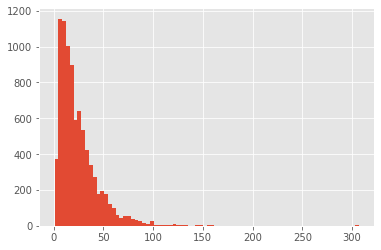

In [22]:
# Show a histogram distribution of the length of sentences within the dataset
plt.hist([len(s) for s in sentences], bins=80)
plt.show()

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# The "dimensions" is the number of "features" or numbers in each static word embedding. 
# We used "glove.6B.200d.txt" which, for each static word embedding, provides numerical vectors of length 200 
# for each word in its datafile.
numberOfEmbeddings = 400001
dimensions = 200
max_len = 50

# Used to build the collection of static word embeddings 
embeddings = np.zeros((numberOfEmbeddings, dimensions))

# Build a hashmap to later convert tweets from lists of words into lists of integers. 
# These integers represent the numerical position in "embeddings_indexes" where the word that was previously
# in the tweet at that position is located. 
# 
# Together "embeddings" and "embeddings_indexes" allow for the neural network to create a numerical matrix for each tweet. 
# The main idea is that this numerical matrix not only represents the words in a tweet but also captures something more that 
# the neural network can learn. 
embeddings_indexes = {}
embeddings_indexes["padding_token"] = 0
embeddings[0] = np.random.rand(200,)

# Go through all of the static word embeddings in the Glove datafile and 
# extract the word and corresponding numerical static word embedding 
with open(BASE_PATH + glove_file_name) as glove_200embeddings:

    lines = glove_200embeddings.readlines()
    # At this point we have not seen any words nor their word embeddings
    index = 0
    for line in lines:

        tokenized_data_line = line.split()

        # In the case that a static word embedding does not get read by the computer correctly we skip over it
        if len(tokenized_data_line) < dimensions+1:
            continue

        # Extract the word
        embedding_text = tokenized_data_line[0] 
        
        # Extract the numerical static word embedding and convert it into a float
        embedding_values = np.asarray(tokenized_data_line[1:], dtype=np.float32) 
        
        # Remember where this word is to be placed in the embedding collection
        embeddings_indexes[embedding_text] = index + 1

        # Place the numerical static word embedding for a word in the embedding collection
        embeddings[index+1] = embedding_values

        # Increase the number of words we have seen up to this point
        index += 1

In [24]:
X2 = []
y2 = []

# Build the indexed mapped version of every sequence in the dataset
for s in sentences:
  singleVectorX = []
  singleVectorY = []
  for token in s:
    # Check if the token has a static word embedding, if it does save the position of that word embedding to a list
    # This position is relative to the embeddings collection that was created earlier.
    if token[0] in embeddings_indexes:
      singleVectorX.append(embeddings_indexes[token[0]])
    else:
      singleVectorX.append(0)
    
    singleVectorY.append(tag2idx[token[1]])
  X2.append(singleVectorX)
  y2.append(singleVectorY)

In [25]:
# Pad the sequences to be of equal length
X2 = pad_sequences(X2, maxlen=max_len, padding="post")
y2 = pad_sequences(y2, maxlen=max_len, padding="post", value=tag2idx["X"])

In [26]:
# Split the dataset into train, test, and validation sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [27]:
# Imports for building the model 
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [28]:
# Define our embedding layer
embedding_layer = Embedding(numberOfEmbeddings, dimensions, weights=[embeddings],input_length=max_len, trainable=False)

In [29]:
# Define our model
input_word = Input(shape=(max_len,))
model = embedding_layer(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 200)           80000200  
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          240800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 14)           2814      
 ibuted)                                                         
                                                             

In [30]:
# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [31]:
# Declare imports for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

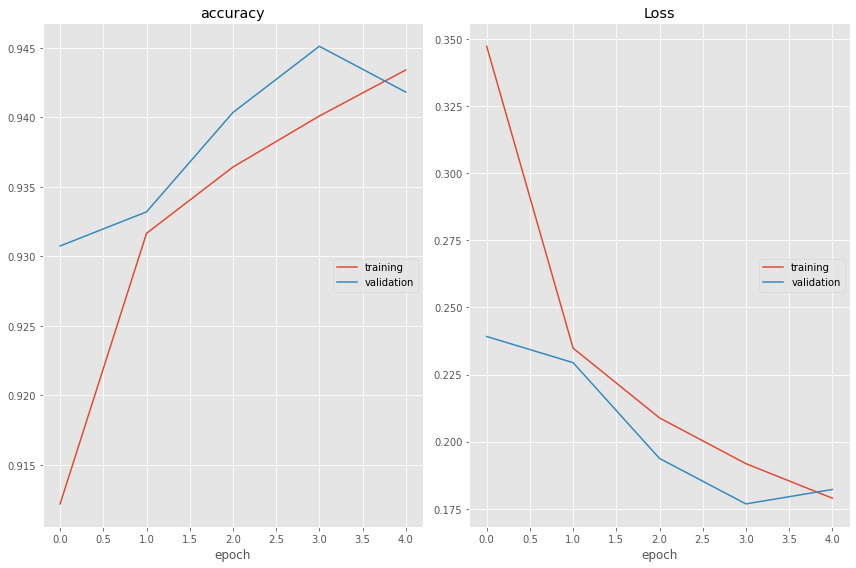

accuracy
	training         	 (min:    0.912, max:    0.943, cur:    0.943)
	validation       	 (min:    0.931, max:    0.945, cur:    0.942)
Loss
	training         	 (min:    0.179, max:    0.347, cur:    0.179)
	validation       	 (min:    0.177, max:    0.239, cur:    0.182)

Epoch 5: val_loss did not improve from 0.17681
188/188 [==============================] - 62s 333ms/step - loss: 0.1789 - accuracy: 0.9434 - val_loss: 0.1822 - val_accuracy: 0.9418


In [32]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.125,
    batch_size=32, 
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

In [33]:
# Save the model
# CHANGE THE PATH BEFORE RUNNING THIS CELL EACH TIME YOU TRAIN A NEW MODEL OR YOU WILL OVERWRITE YOUR PPREVIOUSLY SAVED MODELS!!!!!
BASE_PATH = "/content/drive/MyDrive/NLP 516 Information Extraction/models/"
model_path = "test_model_for_Github"
model.save(BASE_PATH + model_path)

In [34]:
# Reload the model
from tensorflow import keras
model = keras.models.load_model(BASE_PATH + model_path)

### Task 8: Evaluate Named Entity Recognition Model

In [35]:
# Use the build in evaluation for loss and accuracy over a dataset
model.evaluate(x_test, y_test)

54/54 [==============================] - 2s 32ms/step - loss: 0.1872 - accuracy: 0.9415


[0.18720325827598572, 0.9414827823638916]

In [36]:
# Reverse the keys and values of the embeddings indexes dictionary. Allows us to get words back from index numbers
res = dict((v,k) for k,v in embeddings_indexes.items())

i = np.random.randint(0, x_test.shape[0]) # Pull a random sentence
p = model.predict(np.array([x_test[i]])) # Predict over that pulled sentence

# Print a side by side of a sentences words, named entities, and model predictied named entities
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    if tags[true] == "X":
      break
    print("{:15}{}\t{}".format(res[w], tags[true], tags[pred]))

1/1 [==============================] - 0s 438ms/step
Word           True 	 Pred

------------------------------
padding_token  B-LOC	O
padding_token  I-LOC	O
went           O	O
straight       O	O
on             O	O
like           O	O
a              B-FAC	O
tunnel         I-FAC	O
for            O	O
some           O	O
way            O	O
,              O	O
and            O	O
then           O	O
dipped         O	O
suddenly       O	O
down           O	O
,              O	O
so             O	O
suddenly       O	O
that           O	O
padding_token  B-PER	O
had            O	O
not            O	O
a              O	O
moment         O	O
to             O	O
think          O	O
about          O	O
stopping       O	O
herself        O	O
before         O	O
she            O	O
found          O	O
herself        O	O
falling        O	O
down           O	O
a              B-FAC	O
very           I-FAC	O
deep           I-FAC	O
well           I-FAC	O
.              O	O


### Task 9: Manual Evaluation and Confusion Matrix


In [37]:
# Build a function that returns an index value for use in building the confusion matrix
def index_for_confusion_table(param):
    if param == "O":
        return 1
    elif param == "B-PER":
        return 2
    elif param == "I-PER":
        return 3
    elif param == "B-FAC":
        return 4
    elif param == "I-FAC":
        return 5
    elif param == "B-VEH":
        return 6
    elif param == "I-VEH":
        return 7
    elif param == "B-GPE":
        return 8
    elif param == "I-GPE":
        return 9
    elif param == "B-LOC":
        return 10
    elif param == "I-LOC":
        return 11
    elif param == "B-ORG":
        return 12
    elif param == "I-ORG":
        return 13
    else:
      return -1

# Builds a starting dictionary that represents an empty confusion matrix
tagCounts = {
    "O": ["O", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-PER": ["B-PER", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-PER": ["I-PER", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    "B-FAC": ["B-FAC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    "I-FAC": ["I-FAC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-VEH": ["B-VEH", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-VEH": ["I-VEH", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-GPE": ["B-GPE", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-GPE": ["I-GPE", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-LOC": ["B-LOC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-LOC": ["I-LOC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-ORG": ["B-ORG", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-ORG": ["I-ORG", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

In [38]:
from sys import argv
from prettytable import PrettyTable, ALL, DOUBLE_BORDER

incIndex = 0
total_tagged_values = 0
correct_tags = 0

# For every sequence of tokens in the test set
for i in range(x_test.shape[0]):
  p = model.predict(np.array([x_test[i]])) # Predict the entities for that sequence using the model
  p = np.argmax(p, axis=-1)
  y_true = y_test[i]

  # For every token in a sequence
  for w, true, pred in zip(x_test[i], y_true, p[0]):
    # If the true class is a Padding token, we have reached the end of the sequence and break out of the loop
    if tags[true] == "X":
      break

    # If the prediciton and the true class mathc
    if pred == true:
      incIndex = index_for_confusion_table(tags[true]) # Get the index value of the true class in the confusion matrix
      tagCounts[tags[pred]][incIndex] += 1 # Increment the confusion matrix dictionary at position: correct predicition, true class
      correct_tags += 1 # Increment the number of correct tags
    # Otherwise, 
    else:
      incIndex = index_for_confusion_table(tags[true])  # Get the index value of the true class in the confusion matrix
      tagCounts[tags[pred]][incIndex] += 1 # Increment the confusion matrix dictionary at position: incorrect predicition, true class
    total_tagged_values += 1

1/1 [==============================] - 0s 44ms/step


In [39]:
# Build the Confusion Matrix as a Pretty table for nice display
table = PrettyTable()
table.set_style(DOUBLE_BORDER)
table.hrules = ALL
header = ["O", "B-PER", "I-PER", "B-FAC", "I-FAC", "B-VEH", "I-VEH", "B-GPE", "I-GPE", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]
header.insert(0, " ")
table.field_names = header

for values in tagCounts.values():
    table.add_row(values)

In [40]:
# Define a function to calculate Precision, Recall, and F1-Score
def calc_p_r_f1(entity,indexValue,confusionMatrix):
  allEntities = confusionMatrix.keys()
  # Calculate True Positive
  truePositive = confusionMatrix[entity][indexValue]

  # Calculate False Positive
  falsePositive = 0
  for index in range(1,(len(confusionMatrix[entity]))):
    if index == indexValue:
      continue
    else:
      falsePositive += confusionMatrix[entity][index]

  # Calculate False Negative
  falseNegative = 0
  for element in allEntities:
    if element == entity:
      continue
    else:
      falseNegative += confusionMatrix[element][indexValue]
      
  # Calculate Precision
  if truePositive <= 0 and falsePositive <= 0:
    precision = 0
  else:
    precision = ( truePositive / ( truePositive + falsePositive ))

  # Calculate Recall
  if truePositive <= 0 and falseNegative <= 0:
    recall = 0
  else:
    recall = ( truePositive / ( truePositive + falseNegative ))

  # Calculate f1-Score
  if precision <= 0 and recall <= 0:
    f1 = 0
  else:
    f1 = ( 2 * (( precision * recall ) / ( precision + recall )))
  return precision, recall, f1

In [41]:
strNamedEntity = "Named Entity"
strPrecision = "Precision"
strRecall = "Recall"
strF1 = "F1-Score"
strSup = "Support"
print("Classification Report for BiLSTM Model\n")
print(f'{"="*81}')
print(f"|{strNamedEntity:^15s}|{strPrecision:^15s}|{strRecall:^15s}|{strF1:^15s}|{strSup:^15s}|")
print(f'{"="*81}')

for namedEntity in header[1:]:
    indexValue = index_for_confusion_table(namedEntity) 

    # Calculate Performance Measures for each named entity class
    precision, recall, f1 = calc_p_r_f1(namedEntity,indexValue, tagCounts) 
    support = sum(tagCounts[namedEntity][1:])
    
    # Print Performance Measures
    print(f"|{namedEntity:^15s}|{precision:>15.4f}|{recall:>15.4f}|{f1:>15.4f}|{support:^15}|")
print(f'{"="*81}')

# Print the Manually found Accuracy
print("\nAccuracy score is : " + str((correct_tags/total_tagged_values)*100) + " %\n")

# Print the confusion matrix
print("\nConfusion Matrix\n")
print(table.get_string())

Classification Report for BiLSTM Model

| Named Entity  |   Precision   |    Recall     |   F1-Score    |    Support    |
|       O       |         0.9193|         0.9517|         0.9352|     32588     |
|     B-PER     |         0.7024|         0.4860|         0.5745|      988      |
|     I-PER     |         0.5596|         0.6134|         0.5852|     3224      |
|     B-FAC     |         0.5727|         0.3662|         0.4467|      227      |
|     I-FAC     |         0.4482|         0.4429|         0.4455|      917      |
|     B-VEH     |         0.0000|         0.0000|         0.0000|       0       |
|     I-VEH     |         0.5000|         0.1316|         0.2083|      10       |
|     B-GPE     |         1.0000|         0.0182|         0.0357|       2       |
|     I-GPE     |         0.4545|         0.0420|         0.0769|      11       |
|     B-LOC     |         0.6765|         0.1465|         0.2408|      34       |
|     I-LOC     |         0.6441|         0.2105|         

### Task 10: Inference over Tweets from Twitter

In [42]:
# Set the file paths for the files within google drive
BASE_PATH = "/content/drive/MyDrive/NLP 516 Information Extraction/Data/"
dataset_file_path = "betterTweets.csv"

# Load the dataset into a pandas dataframe
data = pd.read_csv(BASE_PATH + dataset_file_path, encoding="utf-8")
data = data.fillna(method="ffill")

# Print the first 30 rows of the loaded dataframe
data.head(30)

,Sentence,Word,Named Entity
0,1,https://t.co/CzfTXhfWQ9,O
1,1,Watch,O
2,1,live,O
3,1,online,O
4,1,now,O
5,1,|,O
6,1,Faur\xc3\xa9,O
7,1,Requiem,O
8,1,-,O
9,1,Dedicated,O


In [43]:
# Builds a frequency dictionary of each named entity class
entities = data["Named Entity"].unique()
count_dict = {}
for entity in entities:
  count_dict[entity] = len(data[data["Named Entity"] == entity])

In [44]:
count_dict

{'O': 53803,
 'B-PER': 2576,
 'I-PER': 1766,
 'B-LOC': 722,
 'I-LOC': 667,
 'B-ORG': 515,
 'B-FAC': 524,
 'I-FAC': 196,
 'B-GPE': 2086,
 'I-GPE': 510,
 'I-ORG': 277,
 'B-VEH': 63,
 'I-VEH': 32}

In [45]:
# Prints rows from the loaded dataframe that are not of the "O" class of named entities
data[data["Named Entity"] != entities[0]]

,Sentence,Word,Named Entity
14,1,Her,B-PER
15,1,Majesty,I-PER
16,1,#QueenElizabethII,I-PER
41,3,Leon,B-PER
42,3,",",I-PER
...,...,...,...
63674,4041,Moscow,B-GPE
63686,4042,#tanks,B-VEH
63690,4043,@TdpVenkata,B-PER
63712,4044,#AndhraPradesh,B-GPE


In [46]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Named Entity'].nunique())

Unique words in corpus: 15896
Unique tags in corpus: 13


In [47]:
# Use the custom class to get each sentence as a list of 2-tuple pairs from the dataset
getter = SentenceGetter(data)
sentences = getter.sentences

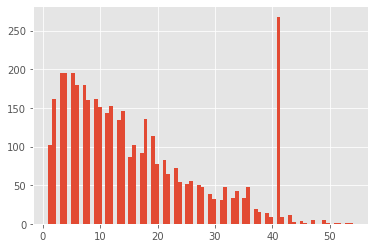

In [48]:
# Show a histogram distribution of the length of sentences within the dataset
plt.hist([len(s) for s in sentences], bins=80)
plt.show()

In [49]:
X3 = []
y3 = []
# Build the indexed mapped version of every sequence in the dataset
for s in sentences:
  singleVectorX = []
  singleVectorY = []
  for token in s:
    # Check if the token has a static word embedding, if it does save the position of that word embedding to a list
    # This position is relative to the embeddings collection that was created earlier.
    if token[0] in embeddings_indexes:
      singleVectorX.append(embeddings_indexes[token[0]])
    else:
      singleVectorX.append(0)
    
    singleVectorY.append(tag2idx[token[1]])
  X3.append(singleVectorX)
  y3.append(singleVectorY)

In [50]:
# Pad the sequences
X3 = pad_sequences(X3, maxlen=max_len, padding="post")
y3 = pad_sequences(y3, maxlen=max_len, padding="post", value=tag2idx["X"])

In [51]:
# Use the built in evaluation to determine loss and accuracy over a dataset
model.evaluate(X3, y3)

126/126 [==============================] - 4s 31ms/step - loss: 0.9723 - accuracy: 0.8665


[0.9723179340362549, 0.8664590120315552]

In [52]:
# Reverse the keys and values of the embeddings indexes dictionary. Allows us to get words back from index numbers
res = dict((v,k) for k,v in embeddings_indexes.items())

i = np.random.randint(0, X3.shape[0]) # Pull a random sentence
p = model.predict(np.array([X3[i]])) # Predict over that pulled sentence

# Print a side by side of a sentences words, named entities, and model predictied named entities
p = np.argmax(p, axis=-1)
y_true = y3
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X3[i], y3[i], p[0]):
    if tags[true] == "X":
      break
    print("{:15}{}\t{}".format(res[w], tags[true], tags[pred]))

1/1 [==============================] - 0s 38ms/step
Word           True 	 Pred

------------------------------
padding_token  B-PER	O
,              O	O
incorporate    O	O
padding_token  O	O
into           O	O
your           O	O
next           O	O
lesson         O	O
!              O	O


In [53]:
# Builds a starting dictionary that represents an empty confusion matrix
tagCounts = {
    "O": ["O", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-PER": ["B-PER", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-PER": ["I-PER", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    "B-FAC": ["B-FAC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    "I-FAC": ["I-FAC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-VEH": ["B-VEH", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-VEH": ["I-VEH", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-GPE": ["B-GPE", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-GPE": ["I-GPE", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-LOC": ["B-LOC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-LOC": ["I-LOC", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "B-ORG": ["B-ORG", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I-ORG": ["I-ORG", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

incIndex = 0
total_tagged_values = 0
correct_tags = 0

for i in range(X3.shape[0]):
  p = model.predict(np.array([X3[i]]))
  p = np.argmax(p, axis=-1)
  y_true = y3[i]

  for w, true, pred in zip(X3[i], y_true, p[0]):
    if tags[true] == "X" or tags[pred] == "X":
      break
    if pred == true:
      incIndex = index_for_confusion_table(tags[true])
      tagCounts[tags[pred]][incIndex] += 1
      correct_tags += 1
    else:
      incIndex = index_for_confusion_table(tags[true])
      tagCounts[tags[pred]][incIndex] += 1
    total_tagged_values += 1


1/1 [==============================] - 0s 48ms/step


In [54]:
# Build the Confusion Matrix
table2 = PrettyTable()
table2.set_style(DOUBLE_BORDER)
table2.hrules = ALL
header2 = ["O", "B-PER", "I-PER", "B-FAC", "I-FAC", "B-VEH", "I-VEH", "B-GPE", "I-GPE", "B-LOC", "I-LOC", "B-ORG", "I-ORG"]
header2.insert(0, " ")
table2.field_names = header2

for values in tagCounts.values():
    table2.add_row(values)

In [55]:
strNamedEntity = "Named Entity"
strPrecision = "Precision"
strRecall = "Recall"
strF1 = "F1-Score"
strSup = "Support"

print("Classification Report for BiLSTM Model\n")
print(f'{"="*81}')
print(f"|{strNamedEntity:^15s}|{strPrecision:^15s}|{strRecall:^15s}|{strF1:^15s}|{strSup:^15s}|")
print(f'{"="*81}')

for namedEntity in header2[1:]:
    indexValue = index_for_confusion_table(namedEntity)
    precision, recall, f1 = calc_p_r_f1(namedEntity,indexValue, tagCounts) # Calculate Performance Metrics
    support = sum(tagCounts[namedEntity][1:])
    # Print Performance Metrics
    print(f"|{namedEntity:^15s}|{precision:>15.4f}|{recall:>15.4f}|{f1:>15.4f}|{support:^15}|")
print(f'{"="*81}')
# Print the Manually found Accuracy
print("\nAccuracy score is : " + str((correct_tags/total_tagged_values)*100) + " %\n")
# Print the confusion matrix
print("\nConfusion Matrix\n")
print(table2.get_string())

Classification Report for BiLSTM Model

| Named Entity  |   Precision   |    Recall     |   F1-Score    |    Support    |
|       O       |         0.9282|         0.8447|         0.8845|     38062     |
|     B-PER     |         0.3380|         0.2964|         0.3158|     1648      |
|     I-PER     |         0.1439|         0.4758|         0.2210|     5601      |
|     B-FAC     |         0.0064|         0.0157|         0.0091|      471      |
|     I-FAC     |         0.0230|         0.4000|         0.0435|     3128      |
|     B-VEH     |         0.0000|         0.0000|         0.0000|       0       |
|     I-VEH     |         0.0000|         0.0000|         0.0000|       2       |
|     B-GPE     |         0.0000|         0.0000|         0.0000|       2       |
|     I-GPE     |         0.0000|         0.0000|         0.0000|      47       |
|     B-LOC     |         0.0000|         0.0000|         0.0000|      21       |
|     I-LOC     |         0.0811|         0.0137|         